In [10]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import math
import sys

# directly use algorithm module
sys.path.append('..')
from algorithm.periodicity_classification.fft import is_periodicity
%matplotlib widget

# 1. Data Processing

## 1.1 Data Collection

There are currently two data sources:
- High availability prometheus thanos
- Operational data elasticsearch

At present, the offline evaluation data uses the prometheus python client to directly obtain raw data.

## 1.2 EDA(Exploratory data analysis)

In [5]:
'''
Data clean function collection.
'''

# avoid not same namespace but same name
# max cpu usage less than 0.05 is dropped.
def choose_cpu_usage_column_name(df):
    columns = df.columns
    sequence = "cpu_usage"
    for c in columns:
        if (sequence in c):
            return c
    return "not found"

def load_csv_data(csv_path):
    raw = pd.read_csv(csv_path)
    df = pd.DataFrame(data=raw)
    return raw, df


def clean_data(raw):
    df = pd.DataFrame(data=raw)
    # delete duplication name data
    unique_names = raw["prometheus.labels.owner_name"].unique()
    
    cpu_usage_column_name = choose_cpu_usage_column_name(df)
    needed_result_dict={}
    max_less_dict={}
    
    # delete max_cpu_usage is too small data, 0.05
    for i in range(len(unique_names)):
        data_by_name = df.loc[df['prometheus.labels.owner_name']==unique_names[i]]
        # index from 0 start
        data_by_name = data_by_name.reset_index()
        diff_ns = (data_by_name["prometheus.labels.namespace"].unique() != data_by_name[0:1]["prometheus.labels.namespace"])
        if diff_ns.bool() : print(diff_ns)
        data_by_name[cpu_usage_column_name] = [float(str(i).replace(",", "")) for i in data_by_name[cpu_usage_column_name]]
        seq_cpu_usage = data_by_name[cpu_usage_column_name]
        name = data_by_name["prometheus.labels.owner_name"][0]
        namespace = data_by_name["prometheus.labels.namespace"][0]
        namespaced_name = str(name)+"_"+str(namespace)
        # if cpu usage is too small, set it to zero, 0.0001
        seq_cpu_usage[seq_cpu_usage < 1e-4] = 0
        # cpu_usage is too small 
        if data_by_name[cpu_usage_column_name].max() < 0.05:
            max_less_dict[namespaced_name] = seq_cpu_usage
            continue
        needed_result_dict[namespaced_name] = seq_cpu_usage
    
    return needed_result_dict, max_less_dict
def choose_memory_usage_column_name(df):
    columns = df.columns
    sequence = "memory_usage"
    for c in columns:
        if (sequence in c):
            return c
    return "not found"

def clean_container_data_cpu_usage(raw):
    df = pd.DataFrame(data=raw)
    # delete duplication name data
    unique_names = raw["prometheus.labels.name"].unique()
    
    cpu_usage_column_name = choose_cpu_usage_column_name(df)
    needed_container_cpu_usage_dict={}
    max_less_container_cpu_usage_dict={}
    
    # delete max_cpu_usage is too small data, 0.05
    for i in range(len(unique_names)):
        data_by_name = df.loc[df['prometheus.labels.name']==unique_names[i]]
        # index from 0 start
        data_by_name = data_by_name.reset_index()
       
        diff_ns = (data_by_name["prometheus.labels.namespace"].unique() != data_by_name[0:1]["prometheus.labels.namespace"])
        if diff_ns.bool() : print(diff_ns)
        data_by_name[cpu_usage_column_name] = [float(str(i).replace(",", "")) for i in data_by_name[cpu_usage_column_name]]
        seq_cpu_usage = data_by_name[cpu_usage_column_name]
        name = data_by_name["prometheus.labels.container_name"][0]
        namespace = data_by_name["prometheus.labels.namespace"][0]
        namespaced_name = str(name)+"_"+str(namespace)+"_"+str(unique_names[i])
        # if cpu usage is too small, set it to zero, 0.0001
        seq_cpu_usage[seq_cpu_usage < 1e-4] = 0
        # cpu_usage is too small 
        if data_by_name[cpu_usage_column_name].max() < 0.05:
            max_less_container_cpu_usage_dict[namespaced_name] = seq_cpu_usage
            continue
        needed_container_cpu_usage_dict[namespaced_name] = seq_cpu_usage
    return needed_container_cpu_usage_dict, max_less_container_cpu_usage_dict

def clean_container_data_memory_usage(raw):
    df = pd.DataFrame(data=raw)
    # delete duplication name data
    unique_names = raw["prometheus.labels.name"].unique()
    
    memory_usage_column_name = choose_memory_usage_column_name(df)
    needed_container_memory_usage_dict={}
    max_less_container_memory_usage_dict={}
    
    # delete max_memory_usage is too small data, 50m
    for i in range(len(unique_names)):
        data_by_name = df.loc[df['prometheus.labels.name']==unique_names[i]]
        # index from 0 start
        data_by_name = data_by_name.reset_index()
        diff_ns = (data_by_name["prometheus.labels.namespace"].unique() != data_by_name[0:1]["prometheus.labels.namespace"])
        if diff_ns.bool() : print(diff_ns)
        data_by_name[memory_usage_column_name] = [float(str(i).replace(",", "")) for i in data_by_name[memory_usage_column_name]]
        seq_memory_usage = data_by_name[memory_usage_column_name]
        name = data_by_name["prometheus.labels.container_name"][0]
        namespace = data_by_name["prometheus.labels.namespace"][0]
        namespaced_name = str(name)+"_"+str(namespace)+"_"+str(unique_names[i])
        # if cpu usage is too small, set it to zero, 10m
        seq_memory_usage[seq_memory_usage < 10] = 0
        # cpu_usage is too small 
        if data_by_name[memory_usage_column_name].max() < 50:
            max_less_container_memory_usage_dict[namespaced_name] = seq_memory_usage
            continue
        needed_container_memory_usage_dict[namespaced_name] = seq_memory_usage
    
    return needed_container_memory_usage_dict, max_less_container_memory_usage_dict

In [16]:
'''
Load application data for evaluatation, only from two kubernetes clusters.
Here we have desensitized, so the above data processing method will not be used
'''
# from different cluster, all is 15 days data.
_,cpu_data_20220418_20220502_0a9obzx3 = load_csv_data("../../dataset/crane_production_cpu_series_data/cls-0a9obzx3_2022-04-18_2022-05-02_cpu_data.csv")
_, cpu_label_data_20220418_20220502_0a9obzx3 =load_csv_data("../../dataset/crane_production_cpu_series_data/cls-0a9obzx3_2022-04-18_2022-05-02_cpu_label_data.csv")

_, cpu_data_20220425_20220509_4g9b5b18 = load_csv_data("../../dataset/crane_production_cpu_series_data/cls-4g9b5b18_2022-04-25_2022-05-09_cpu_data.csv")
_, cpu_label_data_20220425_20220509_4g9b5b18 = load_csv_data("../../dataset/crane_production_cpu_series_data/cls-4g9b5b18_2022-04-25_2022-05-09_cpu_label_data.csv")

In [39]:
cpu_data_20220418_20220502_0a9obzx3

,name,0,1,2,3,4,5,6,7,8,...,43190,43191,43192,43193,43194,43195,43196,43197,43198,43199
0,5c6f227f72fcd3e8afa9bcecb750fcf39b29179672e0ec...,15.905731,15.905731,15.877003,15.904087,15.894917,15.893327,15.883926,15.926782,15.886019,...,15.894601,15.888646,15.896422,9.371555,12.615230,15.858904,15.858904,15.877051,15.895197,15.810820
1,f0bbceedc2a5e3b01ffb3458f3214d77d2b8199dfca4ec...,13.002207,13.002207,15.898139,15.901330,15.893603,15.887963,15.889745,15.908285,15.926825,...,15.899605,15.898133,15.893872,15.926628,15.759756,15.758746,15.921576,15.906562,15.903700,15.897042
2,bdcb18f3207e808034a406f7ddd0e07fa05a684555b549...,15.897643,15.891440,15.891553,15.890491,15.889430,15.888368,15.861042,15.881927,15.899435,...,15.736604,15.325692,15.488864,15.487845,15.447081,15.721077,15.473570,9.148252,14.947202,15.379461
3,141dc8fef7290f6836092124d7583e15432bf52ae6d863...,15.916290,15.892945,15.888390,15.897428,15.900345,15.874614,15.877744,15.880875,15.884005,...,15.908247,10.415479,14.939490,15.802357,15.909593,15.789532,15.892577,8.448858,15.030909,15.891068
4,daf1d37e9b90eb7eddbffbc22ee25300a4701e82f23fe9...,15.909098,15.904523,15.892445,15.903745,15.900111,15.885084,15.898483,15.880865,15.896084,...,15.891809,15.896533,15.866395,15.838297,15.911283,15.872857,15.903935,15.882912,15.894397,15.882978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,8a9765d187d5d003db4dc384872a03e28ae4dd0fc0917a...,6.204886,6.982862,7.743057,7.239710,6.959378,6.778657,6.643117,6.563317,6.320240,...,6.882953,6.971140,7.059327,7.147514,6.864462,6.957307,6.872295,6.879957,6.827847,6.889082
79,ed4c3dd43c4365924f7f6d6f7907c7c5b1deb82b625c84...,6.109378,7.516785,7.529054,7.023784,6.780328,6.714584,6.436675,6.458767,6.272877,...,6.832295,6.896863,6.922290,6.997795,6.876322,6.891447,6.827882,6.828145,6.725867,6.833810
80,21fa5f3889edba780731baf86488f4d032521641502771...,6.020298,6.079919,7.599043,7.336611,6.594916,6.594916,6.610365,6.625814,6.163793,...,6.688571,6.630692,6.748179,6.748179,6.671557,6.594935,6.594935,6.610860,6.626784,6.606681
81,0db643fe18da9f0c61c915afcf23881264e7fc390b2301...,6.009418,6.551420,7.627280,7.200889,6.749594,6.602527,6.361942,6.494897,6.181675,...,6.665071,6.760548,6.711333,7.107002,6.675252,6.749501,6.660822,7.001577,6.595190,6.668110


In [38]:
cpu_label_data_20220418_20220502_0a9obzx3

,name,is_cycle
0,95a74d1ea07429f490933b60e7038d2f9a58c5e9507742...,0
1,6b8c09b421e9baa7aa7bb37062fc19a0601e90ee8ae416...,1
2,ca60177259e3fe7d14814f2e82eb38b2b820bde80d2fdc...,1
3,b928d76aab4ffe8452d7cc610f28da376dee8d8208491b...,1
4,db898ddca2cb94f71e8e1c526e553dbb4fea803d98d84a...,1
5,929a5253510bb3c009d663d72e47dc0301f3e6b987ca39...,1
6,36587de104294e11a02ed6369d604b9cbdc5c88c2f30fe...,1
7,6f97c43dfa00f2ed8f9f3f53136a70a7b603624c5cce56...,1
8,a9988b37209f6b983729d9d06f47152e8e1b96cba8d4d9...,1
9,9ec7eaa42a6985d8ca0672236032c54b264c5bfff0c0c7...,1


In [8]:
# compare with crane test case, to validate the algorithm is right.
# 1. read crane test csv
samples_crane_test_data = []
for i in range(16):
    sample, sample_df = load_csv_data('../../dataset/crane_test_data/input{}.csv'.format(i))
    samples_crane_test_data.append(sample_df)

# 2. FFT, Max prediction algorithm - resource planning

In [1]:
'''
Crane v0.3.0 fft and max prediction.
'''

import logging
from scipy.fft import fft, ifft

# default estimator is fft estimator with different parameters
# min_spectrum_items_nums low_amplitude_threshould margin
# 3  1.0  0.01-0.20
# 50 0.05 0.01-0.20

def update_aggregate_signals(data, sample_interval, cycle_duration,last_timestamp,*args):
# no need for double check signal fit double cycle_duration, already check in is_periodicity
    args = args[0]
    sample_rate = 1.0 / sample_interval
    n = int(cycle_duration * sample_rate)
    m = 0
    i = len(data)
    while (i-n >=0):
        i-=n
        m += 1
    data = data[i:]
    if m < 2:
        return None
    sample_per_cycle = int(len(data)/m)
    history = data[:(m-1)*sample_per_cycle]
    actual = data[(m-1)*sample_per_cycle:]
    min_pe = sys.float_info.max
    best_estimator = {}
    for i in range(len(args)):
        estimator = args[i]["estimator"]
        if estimator == "fft":
            estimated = fft_get_estimator(data,sample_interval,cycle_duration,args[i:i+1])
        elif estimator == "max":
            estimated = max_get_estimator(data,sample_interval,cycle_duration,args[i:i+1])
        else:
            return None
        
        if not estimated.empty:
            estimated = estimated['sample']
            pe = predict_error(actual,estimated)
            logging.info("Testing estimators ...", "estimator", estimator, "pe", pe)
            if pe < min_pe:
                min_pe = pe
                best_estimator = args[i]
    result = pd.DataFrame(columns=['timestamp', 'sample'])    
    if best_estimator:
        if best_estimator['estimator'] == "fft":
            estimated = fft_get_estimator(data,sample_interval,cycle_duration,args[i:i+1])
        elif estimator == "max":
            estimated = max_get_estimator(data,sample_interval,cycle_duration,args[i:i+1])
        next_timestamp = last_timestamp
        cycles = 1
        if cycle_duration == 60*60:
            cycles = 24
        n = len(estimated)
        samples = np.zeros(n*cycles)
        timestamps = np.zeros(n*cycles)
        for c in range(cycles):
            for i in range(n):
                samples[i+c*n] = estimated['sample'][i]
                next_timestamp += sample_interval
                timestamps[i+c*n] = int(next_timestamp)
        
        result['timestamp'] =  timestamps
        result['sample'] = samples
        
    return result

def fft_get_estimator(data,sample_interval,cycle_duration,*args):
    args = args[0]
    sample_rate = 1.0/sample_interval
    # result = pd.DataFrame(columns=['amp', 'freq','sample_rate','sample'])
    result = pd.DataFrame(columns=['sample_rate','sample'])
    fft_y = fft(data)
    sample_length = len(data)
    amps = np.abs(fft_y)/sample_length*2
    # result['freq'] = sample_rate*np.arange(sample_length)/sample_length
    freqs = sample_rate*np.arange(sample_length)/sample_length
    result['sample_rate'] = sample_rate
    max_spectrum_items_nums = args[0]["max_spectrum_items_nums"]
    min_spectrum_items_nums = args[0]["min_spectrum_items_nums"]
    low_amplitude_threshould = args[0]["low_amplitude_threshould"]
    high_frequency_threshold = args[0]["high_frequency_threshold"]
    margin = args[0]["margin"]
    
    # amps = amps[1:int(len(amps)/2)]
    amps[::-1].sort() # reverse sort
    if len(amps) > max_spectrum_items_nums:
        min_amplitude = amps[max_spectrum_items_nums-1]
    else:
        min_amplitude = amps[-1]
    
    if min_amplitude < low_amplitude_threshould :
        min_amplitude = low_amplitude_threshould
        
    if (len(amps) >= min_spectrum_items_nums) & (amps[min_spectrum_items_nums-1]<min_amplitude):
        min_amplitude = amps[min_spectrum_items_nums-1]
    # Filter out the noise, which is of high frequency and low amplitude
    np.where((amps < min_amplitude)&(freqs > high_frequency_threshold),amps,0.0)
    '''
    for i in range(len(amps)):
        # Filter out the noise, which is of high frequency and low amplitude
        if (amps[i] < min_amplitude) & (freqs[i] > high_frequency_threshold):
             amps[i] = 0.0
    '''
    
    ifft_y = ifft(fft_y)
   
    n_samples_per_cycle = int(cycle_duration*sample_rate)
    samples=np.zeros(n_samples_per_cycle)
    for i in np.arange(len(ifft_y) - n_samples_per_cycle,len(ifft_y),1):
        a = np.real(ifft_y[i])
        if a <=0.0:
            a = 0.01
        samples[i+n_samples_per_cycle-len(ifft_y)] = a*(1.0+margin)
    result['sample'] = samples
    return result
    
def max_get_estimator(data,sample_interval,cycle_duration,*args):
    args = args[0]
    margin = args[0]["margin"]
    sample_rate = 1.0/sample_interval
    result = pd.DataFrame(columns=['sample_rate','sample'])
    result['sample_rate'] = sample_rate
    n_samples_per_cycle = int(cycle_duration*sample_rate)
    samples = np.zeros(n_samples_per_cycle)
    n_samples = len(data)
    n_cycles = int(n_samples/n_samples_per_cycle)
    index = 0
    for i in np.arange(n_samples-n_samples_per_cycle,n_samples,1):
        max_value = data[i]
        # get max value in all cycles.
        for j in np.arange(1,n_cycles,1):
            if max_value < data[i-n_samples_per_cycle*j]:
                max_value = data[i-n_samples_per_cycle*j]
        samples[index] = max_value*(1.0+margin)
        index += 1
    
    result['sample'] = samples
    
    return result

# Amplify x (0.0 < x < 1.0). The bigger x the greater the degree of amplification.
# For example, amplify(0.1) = 0.47 (+370%), amplify(0.5) = 3.1 (+520%)
def amplify(x):
    return -math.log(1.0-x)/math.log(1.25)
    
# from sklearn.metrics import mean_absolute_percentage_error 

def mean_absolute_percentage_error(actual, predict):
    if len(actual) != len(predict):
        raise ValueError("actual and predict signal length is not same")
    
    epsilon = 1e-3
    length = len(actual)
    actual = actual[:length]
    predict = predict[:length]
    err = 0.0
    for i in range(length):
        if actual[i] < epsilon:
            print("actual value is almost 0")
            return 0
        err += abs((predict[i] - actual[i]) / actual[i])
    err = err/length
    return err

# mape with experience
def predict_error(actual, predict):
    if len(actual) != len(predict):
        raise ValueError("actual and predict signal length is not same")
    
    epsilon = 1e-3
    length = len(actual)
    actual = actual[:length]
    predict = predict[:length]
    err = 0.0
    for i in range(length):
        if actual[i] < epsilon:
            print("actual value is almost 0")
            return 0
        if predict[i]<actual[i]:
            err += amplify((actual[i] - predict[i]) / actual[i])
        else:
            err += (predict[i] - actual[i]) / actual[i]
    err = err/length
    #err = mean_absolute_percentage_error(actual, predict)
    return err

def mean_squared_error(actual, predict):
    return np.mean((actual - predict) ** 2, dtype=np.float64)

def normalized_root_mse(actual, predict,normalization='euclidean'):
    actual = np.array(actual)
    predict = np.array(predict)
    if normalization == 'euclidean':
        denom = np.sqrt(np.mean((actual * actual)), dtype=np.float64)
    elif normalization == 'min-max':
        denom = actual.max() - actual.min()
    elif normalization == 'mean':
        denom = actual.mean()
    else:
        raise ValueError("Unsupported norm_type")
    return np.sqrt(mean_squared_error(actual, predict)) / denom

In [2]:
def metrics_predict_error(actuals, predicts, trial_names):
    result = pd.DataFrame(columns=["name","metrics name", "value"])
    metrics_names = []
    values = []
    names = []
    for i in range(len(actuals)):
        actual = actuals[i]
        predict = predicts[i]
        normalized_root_mse_euclidean = normalized_root_mse(actual, predict)
        metrics_names.append("normalized_root_mse_euclidean")
        values.append(normalized_root_mse_euclidean)
        names.append(trial_names[i])
        
        normalized_root_mse_min_max = normalized_root_mse(actual, predict,normalization='min-max')
        metrics_names.append("normalized_root_mse_min_max")
        values.append(normalized_root_mse_min_max)
        names.append(trial_names[i])
        
        normalized_root_mse_mean = normalized_root_mse(actual, predict,normalization='mean')
        metrics_names.append("normalized_root_mse_mean")
        values.append(normalized_root_mse_mean)
        names.append(trial_names[i])
        
        mape_crane = predict_error(actual, predict)
        metrics_names.append("mape_crane")
        values.append(mape_crane)
        names.append(trial_names[i])
        
        mape = mean_absolute_percentage_error(actual, predict)
        metrics_names.append("mape")
        values.append(mape)
        names.append(trial_names[i])
    result["name"] = names
    result["metrics name"] = metrics_names
    result["value"] = values
    return result
        

## 2.1 Test set data - algorithm verification

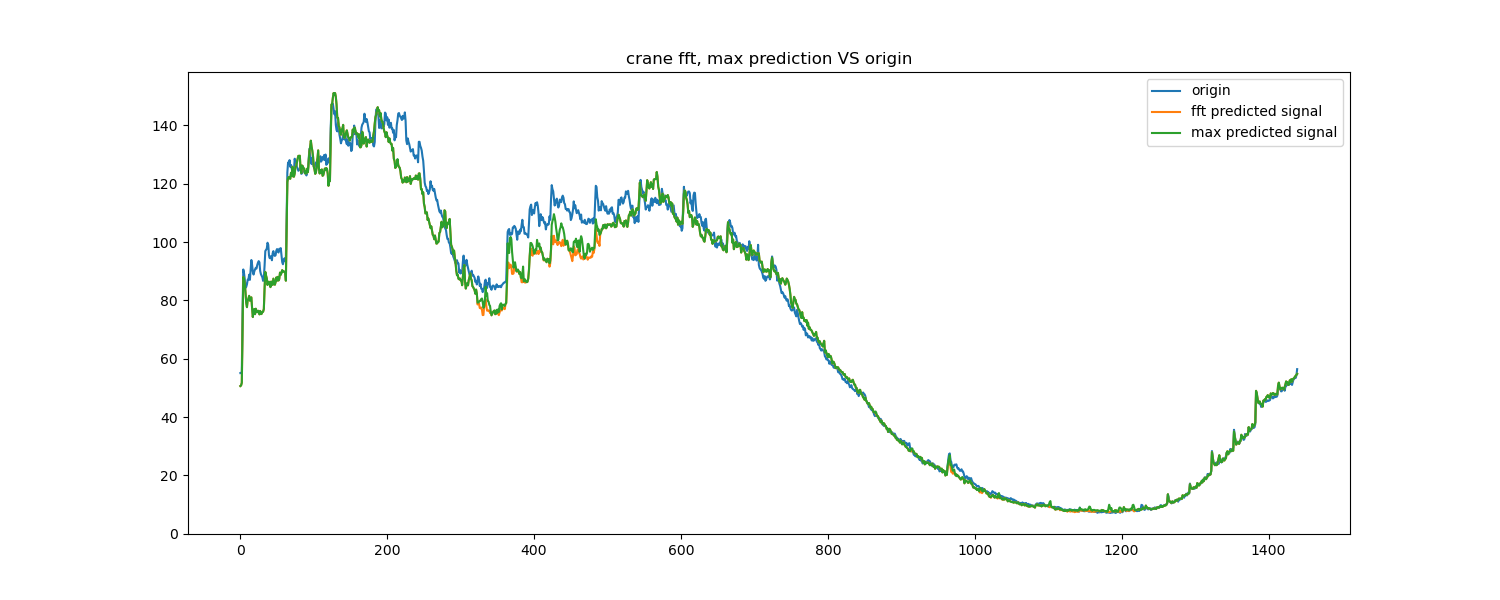

In [11]:
'''
Crane test case for validate the estimator is right.
'''

default_estimators = [
    {"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.01,"estimator": "fft"},
    {"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.10,"estimator": "fft"},
    {"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.15,"estimator": "fft"},
    {"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.20,"estimator": "fft"},
    {"min_spectrum_items_nums": 50, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 0.05, "margin": 0.01,"estimator": "fft"},
    {"min_spectrum_items_nums": 50, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 0.05, "margin": 0.10,"estimator": "fft"},
    {"min_spectrum_items_nums": 50, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 0.05, "margin": 0.15,"estimator": "fft"},
    {"min_spectrum_items_nums": 50, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 0.05, "margin": 0.20,"estimator": "fft"}]



# cycle_duration、min_spectrum_items_nums、max_spectrum_items_nums、high_frequency_threshold、low_amplitude_threshould、margin、estimator
fft_estimators = [{"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.0,"estimator": "fft"}]
max_estimators = [{"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.0,"estimator": "max"}]
sample_interval = 60 # 60s collect one point
sample_rate = 1.0/sample_interval
cycle_duration = 24*60*60
csv0 = samples_crane_test_data[0][:]['value']
csv0_one_day = csv0[1440*7:]
csv0_origin = csv0[:1440*7]
is_cycle, cycles = is_periodicity(csv0_origin.to_numpy(), sample_interval, cycle_duration,show_pic=False)
# print(cycles)
# assert int(cycles[0])==24*60*60
fft_predict = fft_get_estimator(csv0_origin.to_numpy(), sample_interval, cycle_duration,fft_estimators)
max_predict = max_get_estimator(csv0_origin.to_numpy(), sample_interval, cycle_duration,max_estimators)

actuals = []
predicts = []
names=[]

actuals.append(csv0_one_day.to_list())
predicts.append(fft_predict['sample'].to_list())
names.append("origin-fft")

actuals.append(csv0_one_day.to_list())
predicts.append(max_predict['sample'].to_list())
names.append("origin-max")

metrics_predict_errors = metrics_predict_error(actuals,predicts,names)

fig, ax = plt.subplots(figsize=(15,6))
x = np.arange(len(csv0_one_day))
ax.plot(x,csv0_one_day , label='origin')
ax.plot(x, fft_predict['sample'].to_list(), label='fft predicted signal') 
ax.plot(x, max_predict['sample'].to_list(), label='max predicted signal')
ax.legend()
ax.set_title("crane fft, max prediction VS origin")
plt.show()

In [12]:
metrics_predict_errors[metrics_predict_errors['metrics name']=='normalized_root_mse_euclidean']

,name,metrics name,value
0,origin-fft,normalized_root_mse_euclidean,0.073874
5,origin-max,normalized_root_mse_euclidean,0.068269


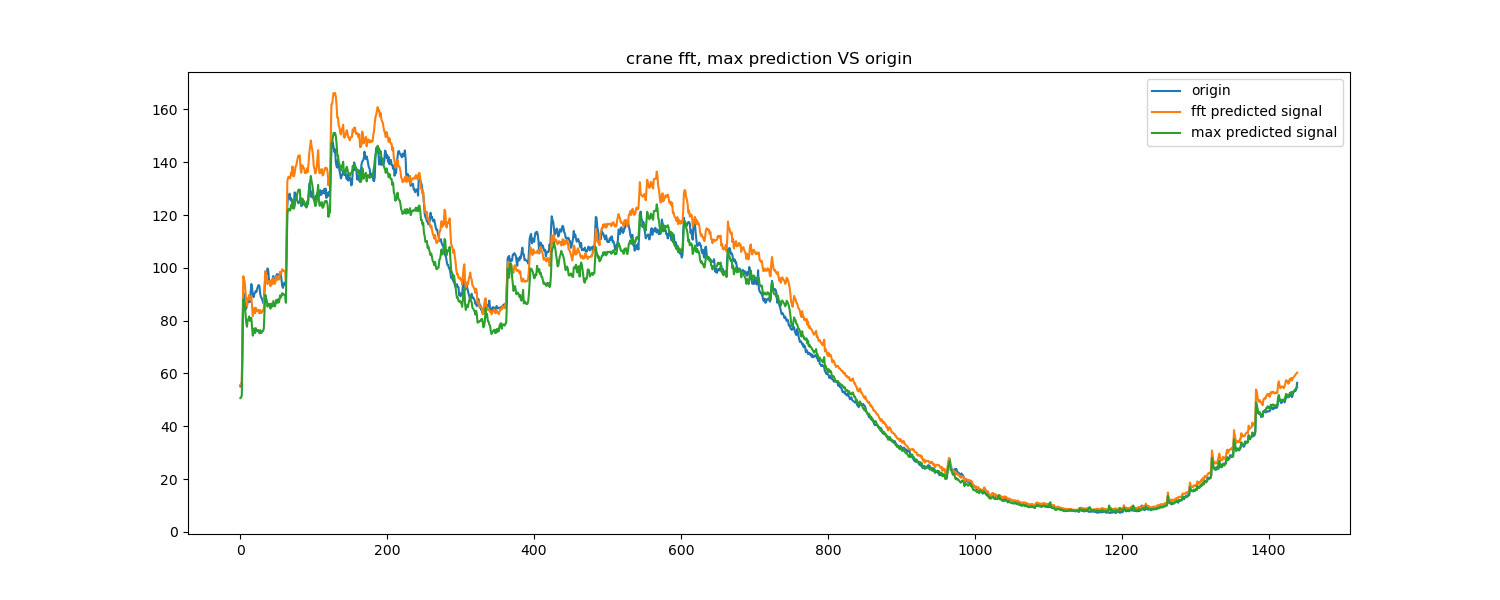

In [13]:
# cycle_duration、min_spectrum_items_nums、max_spectrum_items_nums、high_frequency_threshold、low_amplitude_threshould、margin、estimator
fft_estimators = [{"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.1,"estimator": "fft"}]
max_estimators = [{"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.0,"estimator": "max"}]
sample_interval = 60 # 60s collect one point
sample_rate = 1.0/sample_interval
cycle_duration = 24*60*60
csv0 = samples_crane_test_data[0][:]['value']
csv0_one_day = csv0[1440*7:]
csv0_origin = csv0[:1440*7]
is_cycle, cycles = is_periodicity(csv0_origin.to_numpy(), sample_interval, cycle_duration,show_pic=False)
# print(cycles)
# assert int(cycles[0])==24*60*60
fft_predict = fft_get_estimator(csv0_origin.to_numpy(), sample_interval, cycle_duration,fft_estimators)
max_predict = max_get_estimator(csv0_origin.to_numpy(), sample_interval, cycle_duration,max_estimators)

actuals = []
predicts = []
names=[]

actuals.append(csv0_one_day.to_list())
predicts.append(fft_predict['sample'].to_list())
names.append("origin-fft")

actuals.append(csv0_one_day.to_list())
predicts.append(max_predict['sample'].to_list())
names.append("origin-max")

metrics_predict_errors = metrics_predict_error(actuals,predicts,names)

fig, ax = plt.subplots(figsize=(15,6))
x = np.arange(len(csv0_one_day))
ax.plot(x,csv0_one_day , label='origin')
ax.plot(x, fft_predict['sample'].to_list(), label='fft predicted signal') 
ax.plot(x, max_predict['sample'].to_list(), label='max predicted signal')
ax.legend()
ax.set_title("crane fft, max prediction VS origin")
plt.show()

In [14]:
metrics_predict_errors[metrics_predict_errors['metrics name']=='mape_crane']

,name,metrics name,value
3,origin-fft,mape_crane,0.104557
8,origin-max,mape_crane,0.174833


**注意** 这里主要目的是为了指出，crane v0.3.0 中会根据 mape_crane 的指标确认哪组超参数是最优的。这里带来的问题是，筛选的评估函数和最终拟合度评估函数 (nrmse) 不一致。
也就是你超参数列表给的再多，最终选择的都不一定是 nrmse 最小的。

深入后发现，其实这些超参数只有 margin 对于结果的影响是最大的，其他几乎可以忽略不计。

**优化建议** 如果 crane max/fft 预测结果后期还会有策略，针对每个策略单独评估，这里需要将 crane v0.3.0 中 mape_crane 评估指标替换为 nrmse，增加策略部分，将 margin 分离出来。

**Note** The main purpose here is to point out that in Crane v0.3.0, which set of hyperparameters is optimal according to the mape_crane index. The problem here is that the screening evaluation function and the final fit evaluation function (nrmse) do not agree.
That is, no matter how many hyperparameters you give, the final choice is not necessarily the one with the smallest nrmse.

After digging deeper, it is found that in fact, only the margin of these hyperparameters has the greatest impact on the result, and the others are almost negligible.

**Optimization suggestion** If the crane max/fft prediction result will have a strategy later, each strategy will be evaluated separately. Here, you need to replace the mape_crane evaluation indicator in crane v0.3.0 with nrmse, add the strategy part, and separate the margin.

## 2.2 Algorithm evaluation for production dataset

In [17]:
# validation or estimate for fft and max prediction error.
# cycle_duration、min_spectrum_items_nums、max_spectrum_items_nums、high_frequency_threshold、low_amplitude_threshould、margin、estimator
fft_estimators = [{"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.0,"estimator": "fft"}]
max_estimators = [{"min_spectrum_items_nums": 3, "max_spectrum_items_nums": 100, "high_frequency_threshold": 1.0 / (60.0 * 60.0),
               "low_amplitude_threshould": 1.0, "margin": 0.0,"estimator": "max"}]
sample_interval = 30
sample_rate = 1.0/sample_interval
cycle_duration = 7*24*60*60

# warn: sequence
metrics_predict_errors=[]
for i in range(len(cpu_data_20220418_20220502_0a9obzx3)):
    data = cpu_data_20220418_20220502_0a9obzx3.iloc[i,1:].values
    is_cycle, cycles = is_periodicity(data, sample_interval, cycle_duration,show_pic=False)
    if not is_cycle:
        continue
    index = int(cycle_duration*sample_rate)
    data_origin = data[:index]
    fft_predict = fft_get_estimator(data_origin, sample_interval, cycle_duration,fft_estimators)
    max_predict = max_get_estimator(data_origin, sample_interval, cycle_duration,max_estimators)
    actuals = []
    predicts = []
    names=[]
    length = min(len(fft_predict), len(max_predict))
    data_origin_cycle = data[index:index+length]
    
    
    actuals.append(data_origin_cycle)
    predicts.append(fft_predict['sample'].to_list())
    names.append("origin-fft")

    actuals.append(data_origin_cycle)
    predicts.append(max_predict['sample'].to_list())
    names.append("origin-max")

    mpe = metrics_predict_error(actuals,predicts,names)
    metrics_predict_errors.append(mpe)
    
for i in range(len(cpu_data_20220425_20220509_4g9b5b18)):
    data = cpu_data_20220425_20220509_4g9b5b18.iloc[i,1:].values
    is_cycle, cycles = is_periodicity(data, sample_interval, cycle_duration,show_pic=False)
    if not is_cycle:
        continue
    index = int(cycle_duration*sample_rate)
    data_origin = data[:index]
    fft_predict = fft_get_estimator(data_origin, sample_interval, cycle_duration,fft_estimators)
    max_predict = max_get_estimator(data_origin, sample_interval, cycle_duration,max_estimators)
    actuals = []
    predicts = []
    names=[]
    length = min(len(fft_predict), len(max_predict))
    data_origin_cycle = data[index:index+length]
    
    
    actuals.append(data_origin_cycle)
    predicts.append(fft_predict['sample'].to_list())
    names.append("origin-fft")

    actuals.append(data_origin_cycle)
    predicts.append(max_predict['sample'].to_list())
    names.append("origin-max")
    
    mpe = metrics_predict_error(actuals,predicts,names)
    metrics_predict_errors.append(mpe)

actual value is almost 0
actual value is almost 0
actual value is almost 0
actual value is almost 0


In [18]:
metrics_predict_errors = np.array(metrics_predict_errors)

In [19]:
# origin-fft normalized_root_mse_euclidean
def get_percentile(datas):
    p99=[]
    p95=[]
    p50=[]
    mean=[]
    
    for data in datas:
        mean.append(data.mean()) 
        p99.append(np.percentile(data, 99))
        p95.append(np.percentile(data, 95))
        p50.append(np.percentile(data, 50))
    return  p99,p95,p50,mean

a = metrics_predict_errors[:,0,2] # all origin-fft normalized_root_mse_euclidean
b = metrics_predict_errors[:,1,2] # all origin-fft normalized_root_mse_min_max
c = metrics_predict_errors[:,2,2] # all origin-fft normalized_root_mse_mean
d = metrics_predict_errors[:,3,2] # all origin-fft mape_crane
e = metrics_predict_errors[:,4,2] # all origin-fft mape
f = metrics_predict_errors[:,5,2] # all origin-max normalized_root_mse_mean
g = metrics_predict_errors[:,6,2] # all origin-max normalized_root_mse_min_max
h = metrics_predict_errors[:,7,2] # all origin-max normalized_root_mse_mean
j = metrics_predict_errors[:,8,2] # all origin-max mape_crane
k = metrics_predict_errors[:,9,2] # all origin-max mape

datas = [a,b,c,d,e,f,g,h,j,k]

estimated_result = pd.DataFrame(columns=["name","metrics name", "p99","p95","p50","mean"])

names=["origin-fft","origin-fft","origin-fft","origin-fft","origin-fft","origin-max","origin-max","origin-max","origin-max","origin-max"]
metrics_names=["normalized_root_mse_euclidean","normalized_root_mse_min_max","normalized_root_mse_mean","mape_crane","mape","normalized_root_mse_euclidean","normalized_root_mse_min_max","normalized_root_mse_mean","mape_crane","mape"]

p99,p95,p50,mean=get_percentile(datas)

estimated_result["name"]=names
estimated_result["metrics name"]=metrics_names
estimated_result["p99"]=p99
estimated_result["p95"]=p95
estimated_result["p50"]=p50
estimated_result["mean"]=mean

estimated_result.loc[estimated_result['metrics name']=='normalized_root_mse_euclidean']

,name,metrics name,p99,p95,p50,mean
0,origin-fft,normalized_root_mse_euclidean,1.232135,1.159565,0.178624,0.273063
5,origin-max,normalized_root_mse_euclidean,1.232135,1.159565,0.178624,0.273063


这里的 nrmse 指标显示对于 tke-x 上的 cpu 序列进行周期性预测出的值，max 和 fft 算法区别不大

The nrmse indicator here shows the value predicted periodically for the cpu sequence on tke-x, and the max and fft algorithms are not much different

## 2.3 Scenario Strategy Evaluation

预测算法预测后，消费端根据具体场景进行策略的优化，单纯从算法拟合度上无法确认算法在最终目标的有效性，所以需要对具体场景进行评估。

After the prediction algorithm predicts, the consumer side optimizes the strategy according to the specific scenario. It is impossible to confirm the effectiveness of the algorithm in the final goal simply from the algorithm fit, so it is necessary to evaluate the specific scenario.

### 2.3.1 EHPA

EHPA 通过预测下一周期的信号，可以提前扩容、缩容(replicas) , 预测算法稳定，不会因为毛刺而频繁扩缩容：

目前 EHPA 配置算法参数,具体参见 [code](https://github.com/gocrane/crane/blob/main/pkg/metricprovider/custom_metric_provider.go#L122)：
1. PredictionAlgorithm 算法类型， dsp, max
2. PredictionWindowSeconds 对预测整周期取窗口期， default is 3600s,  1h

如果预测的最后一个时间超过窗口期则，触发 predict
当前 EHPA 会取周期预测值中未来窗口期的最大指标值，作为当前 HPA 的观测指标

By predicting the signal of the next cycle, EHPA can expand and shrink in advance (replicas), the prediction algorithm is stable, and it will not expand or shrink frequently due to glitches:

For the current EHPA configuration algorithm parameters, see [code](https://github.com/gocrane/crane/blob/main/pkg/metricprovider/custom_metric_provider.go#L122):
1. PredictionAlgorithm algorithm type, dsp, max
2. PredictionWindowSeconds takes the window period for the whole prediction period, default is 3600s, 1h

If the last time of the prediction exceeds the window period, trigger predict
The current EHPA will take the maximum index value of the future window period in the periodic forecast value as the observation index of the current HPA

# 3 Conclusion

1. 目前预测准确性使用 nrmse 进行 fft,max 算法拟合度评估
2. 目前的 max 以及 fft 的超参影响较大的为 margin, 其他（频谱最大最小数，频率阈值、最小频谱）基本无影响，评估时需去除 margin 干扰
3. 对于 EHPA 场景下，在拟合度指标相似的前提下，统计提前扩容和提前缩容的次数，评估算法的有效性

1. The current prediction accuracy uses nrmse to evaluate the fit of the fft,max algorithm
2. The current max and fft hyperparameters have a greater impact on margin, and others (maximum and minimum number of spectrum, frequency threshold, and minimum spectrum) basically have no effect, and margin interference needs to be removed during evaluation.
3. For the EHPA scenario, under the premise of similar fit indicators, count the number of pre-expansion and pre-scale reduction to evaluate the effectiveness of the algorithm

### Further Work 

1. 确定 ehpa 的评估指标: 统计提前扩容和提前缩容的次数，弹性总次数（无效缩容（缩容时间间隔 30min)），replicas*request 和 usage 曲线拟合度，
2. 针对存在ehpa dryrun和hpa的业务 进行离线 ehpa 评估
3. max, fft 预测的 margin 乘法替换成横加法作评估比较
4. 需要结合更多的场景进行补充评估，例如剩余资源预测做资源规划、Fadvisor 基于历史账单预测成本等

1. Determine the evaluation indicators of ehpa: count the number of early expansions and early reductions, the total number of elasticities (invalid scaling (scaling interval 30min)), replicas*request and usage curve fitting degree,
2. Offline ehpa assessment for businesses with ehpa dryrun and hpa
3. The margin multiplication of max, fft predictions is replaced by horizontal addition for evaluation and comparison
4. Supplementary evaluation needs to be combined with more scenarios, such as remaining resource prediction for resource planning, Fadvisor's cost prediction based on historical bills, etc.